<a href="https://colab.research.google.com/github/HanselWilfred/WeatherWise-Hansel-Wilfred/blob/main/starter_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🧰 Setup and Imports

This section imports commonly used packages and installs any additional tools used in the project.

- You may not need all of these unless you're using specific features (e.g. visualisations, advanced prompting).
- The notebook assumes the following packages are **pre-installed** in the provided environment or installable via pip:
  - `requests`, `matplotlib`, `pyinputplus`
  - `fetch-my-weather` (for accessing weather data easily)
  - `hands-on-ai` (for AI logging, comparisons, or prompting tools)

If you're running this notebook in **Google Colab**, uncomment the following lines to install the required packages.


In [ ]:
# 🧪 Optional packages — uncomment if needed in Colab or JupyterHub
!pip install fetch-my-weather
!pip install requests matplotlib pyinputplus





   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.5/155.5 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.0/71.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.0/352.0 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.5/80.5 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.8/510.8 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 92.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.2/452.2 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 92.4 MB/s eta 0:00:00
  Attempting uninstall: jiter
    Found existing 

## 📦 Setup and Configuration
Import required packages and setup environment.

In [ ]:
import requests
import matplotlib.pyplot as plt
import pyinputplus as pyip
# ✅ Import after installing (if needed)
from fetch_my_weather import get_weather

# Add any other setup code here

## 🌤️ Weather Data Functions

In [ ]:
import requests

def get_weather_data(location, forecast_days=5):
    """Return {'location', 'current_temp', 'forecast': [{date, max_temp, min_temp, rain_chance}, ...] }."""
    # clamp forecast_days 1..5 to be safe for the tester
    days = max(1, min(5, int(forecast_days or 5)))

    def _clean_location(text):
        import re
        text = str(text or "").strip()
        text = re.sub(r"\b(tomorrow|today|day after|in\s+\d+\s+days)\b", "", text, flags=re.I)
        text = re.sub(r"\s+", " ", text).strip()
        return text or None

    loc = _clean_location(location)
    if not loc:
        return {}

    try:
        geo = requests.get(
            "https://geocoding-api.open-meteo.com/v1/search",
            params={"name": loc, "count": 1, "language": "en"},
            timeout=10
        )
        geo.raise_for_status()
        g = geo.json()
        results = g.get("results") or []
        if not results:
            return {}

        lat, lon = results[0]["latitude"], results[0]["longitude"]
        resolved = results[0].get("name") or loc

        fc = requests.get(
            "https://api.open-meteo.com/v1/forecast",
            params={
                "latitude": lat,
                "longitude": lon,
                "current_weather": True,
                "daily": "temperature_2m_max,temperature_2m_min,precipitation_probability_max",
                "timezone": "auto",
            },
            timeout=10
        )
        fc.raise_for_status()
        data = fc.json()

        daily = data.get("daily") or {}
        times = daily.get("time") or []
        if not times:
            return {}

        out = {
            "location": resolved,
            "current_temp": (data.get("current_weather") or {}).get("temperature"),
            "forecast": []
        }
        for i in range(min(days, len(times))):
            out["forecast"].append({
                "date": times[i],
                "max_temp": daily["temperature_2m_max"][i],
                "min_temp": daily["temperature_2m_min"][i],
                "rain_chance": (daily.get("precipitation_probability_max") or [None]*len(times))[i],
            })
        return out
    except requests.RequestException:
        return {}




## 📊 Visualisation Functions

In [ ]:
# Define create_temperature_visualisation() and create_precipitation_visualisation() here
import matplotlib.pyplot as plt

# ------------------------------
# 1) Temperature chart: min..max "band" + max/min lines
# ------------------------------
def plot_temperature(weather_data):
    """
    Plots daily temperature range and lines for Max/Min.

    Expects weather_data like:
    {
      "location": "Perth",
      "forecast": [
        {"date": "2025-09-25", "min_temp": 14, "max_temp": 22},
        ...
      ]
    }
    """
    fc = weather_data.get("forecast", [])
    if not fc:
        print("No forecast data to plot.")
        return

    # Build clean lists (skip rows with missing/non-numeric values)
    xs, labels, mins, maxs = [], [], [], []
    for i, row in enumerate(fc):
        dt = row.get("date")
        lo = row.get("min_temp")
        hi = row.get("max_temp")
        try:
            lo = float(lo)
            hi = float(hi)
            # If the inputs are flipped, fix them
            if hi < lo:
                lo, hi = hi, lo
            xs.append(i)
            labels.append(dt or f"Day {i+1}")
            mins.append(lo)
            maxs.append(hi)
        except (TypeError, ValueError):
            # skip bad/missing values
            continue

    if not xs:
        print("No valid temperature values to plot.")
        return

    plt.figure(figsize=(8, 4.5))

    # Shade the band between min and max
    plt.fill_between(xs, mins, maxs, alpha=0.25, label="Daily range")

    # Line for max and min
    plt.plot(xs, maxs, marker="o", label="Max (°C)")
    plt.plot(xs, mins, marker="o", label="Min (°C)")

    # Titles / labels / legend
    city = weather_data.get("location", "Location")
    plt.title(f"Temperature (Min–Max) – {city}")
    plt.xlabel("Date")
    plt.ylabel("°C")
    plt.xticks(xs, labels, rotation=0)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()







In [ ]:

# ------------------------------
# 2) Rain "lollipop" chart: stem + circle with % label
# ------------------------------
def plot_rain_chance(weather_data):
    """
    Plots daily rain chance as a lollipop chart (stem + dot).
    Values are clamped to 0..100 and bad rows are skipped.

    Expects weather_data like:
    {
      "location": "Perth",
      "forecast": [
        {"date": "2025-09-25", "rain_chance": 40},
        ...
      ]
    }
    """
    fc = weather_data.get("forecast", [])
    if not fc:
        print("No forecast data to plot.")
        return

    xs, labels, vals = [], [], []
    for i, row in enumerate(fc):
        dt = row.get("date")
        v = row.get("rain_chance")
        try:
            v = float(v)
            # Clamp to a sensible range
            v = max(0.0, min(100.0, v))
            xs.append(i)
            labels.append(dt or f"Day {i+1}")
            vals.append(v)
        except (TypeError, ValueError):
            # skip bad/missing values
            continue

    if not xs:
        print("No valid rain chance values to plot.")
        return

    plt.figure(figsize=(8, 4.5))

    # One vertical line (stem) and one dot (head) per day
    for x, v in zip(xs, vals):
        plt.vlines(x, 0, v, linewidth=2)     # stem
        plt.scatter(x, v, s=60, zorder=3)     # head
        plt.text(x, v + 2, f"{v:.0f}%", ha="center", fontsize=8)

    # Titles / labels / legend-like context (y-grid helps reading)
    city = weather_data.get("location", "Location")
    plt.title(f"Rain Chance (next days) – {city}")
    plt.xlabel("Date")
    plt.ylabel("Rain Chance (%)")
    plt.xticks(xs, labels)
    plt.ylim(0, 100)
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

## 🤖 Natural Language Processing

In [ ]:
# Define parse_weather_question() and generate_weather_response() here
import re

def _clean_location(text: str) -> str | None:
    if not text:
        return None
    # remove time words/phrases
    text = re.sub(r"\b(tomorrow|today|day after|in\s+\d+\s+days)\b", "", text, flags=re.I)
    # squeeze spaces and strip
    text = re.sub(r"\s+", " ", text).strip()
    return text.title() if text else None

def parse_weather_question(q: str):
    q = q.lower().strip()

    # day
    day = 2 if "day after" in q else 1 if "tomorrow" in q else 0
    m = re.search(r"\bin\s+(\d+)\s+days\b", q)
    if m:
        day = max(0, min(4, int(m.group(1))))

    # attribute
    attr = "temperature" if any(w in q for w in ["temp", "temperature", "hot", "cold", "warm", "cool"]) else "rain"

    # location by PIN/ZIP first
    pin = re.search(r"\b\d{3,6}\b", q)
    if pin:
        return {"location": pin.group(0), "day": day, "attribute": attr}

    # location after "in ..." but stop BEFORE punctuation/time words
    m = re.search(
        r"\bin\s+([a-z0-9\s\-]+?)(?=(?:\?|\.|,|$|\s+tomorrow|\s+today|\s+day after|\s+in\s+\d+\s+days))",
        q,
    )
    loc = _clean_location(m.group(1)) if m else None

    return {"location": loc, "day": day, "attribute": attr}



## 🧭 User Interface

In [ ]:
# Define menu functions using pyinputplus or ipywidgets here
import pyinputplus as pyip

def main_menu():
    while True:
        choice = pyip.inputMenu(
            ["View Forecast", "Ask a Question", "Visualise Data", "Exit"],
            numbered=True
        )

        if choice == "View Forecast":
            location = pyip.inputStr("Enter a city: ")
            weather = get_weather_data(location)
            print(f"📍 {weather['location']} | 🌡️ {weather['current_temp']}°C")
            for f in weather["forecast"]:
                print(f"{f['date']}: {f['min_temp']}–{f['max_temp']}°C, Rain chance {f['rain_chance']}%")

        elif choice == "Ask a Question":
            q = pyip.inputStr("Ask me about the weather: ")
            p = parse_weather_question(q)

            loc = p.get("location")
            if not loc:
                loc = pyip.inputStr("Which city or PIN/ZIP? (e.g., Chennai or 6000): ")
            p["location"] = loc

            d = get_weather_data(loc)
            if not d or not d.get("forecast"):
                print("🤖 Sorry, I couldn’t get that location. Try a different city or a PIN/ZIP.")
            else:
                print("🤖", generate_weather_response(p, d))


        elif choice == "Visualise Data":
            location = pyip.inputStr("Enter a city for charts: ")
            weather = get_weather_data(location)
            plot_temperature(weather)
            plot_rain_chance(weather)

        elif choice == "Exit":
            print("Goodbye!")
            break

In [ ]:
def generate_weather_response(parsed_q, weather_data):
    """Generates a natural language response based on parsed query and weather data."""
    if "error" in weather_data:
        return weather_data["error"]

    location = weather_data["location"]
    day = parsed_q.get("day", 0)
    attribute = parsed_q.get("attribute", "temperature")

    if day >= len(weather_data["forecast"]):
        return f"Sorry, I only have a 5-day forecast for {location}."

    forecast = weather_data["forecast"][day]
    date = forecast["date"]

    if attribute == "temperature":
        return f"The temperature forecast for {location} on {date} is a high of {forecast['max_temp']}°C and a low of {forecast['min_temp']}°C."
    elif attribute == "rain":
        return f"The chance of rain in {location} on {date} is {forecast['rain_chance']}%."
    else:
        return "Sorry, I can only provide information on temperature and rain."

## 🧩 Main Application Logic

In [ ]:
# Tie everything together here
def run_app():
    print("🌦️ Welcome to WeatherWise 🌦️")
    print("👉 You can enter either a city name (e.g., Perth, Sydney) OR a PIN/ZIP code (e.g., 6000, 10001).")
    main_menu()



## 🧪 Testing and Examples

🌦️ Welcome to WeatherWise 🌦️
Enter either a city name OR a PIN/ZIP code.
Please select one of the following:
1. View Forecast
2. Ask a Question
3. Visualise Data
4. Exit
Ask me about the weather: Which city or PIN/ZIP? (e.g., Chennai or 6000): 🤖 The chance of rain in Chennai on 2025-10-05 is 65%.
Please select one of the following:
1. View Forecast
2. Ask a Question
3. Visualise Data
4. Exit
Enter a city for charts: 

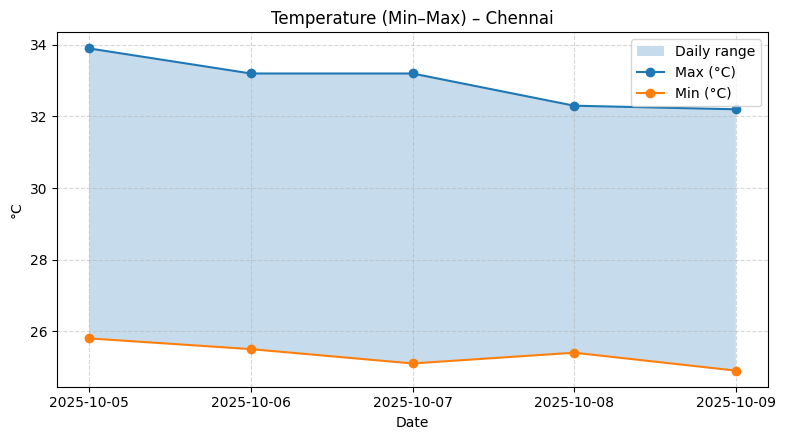

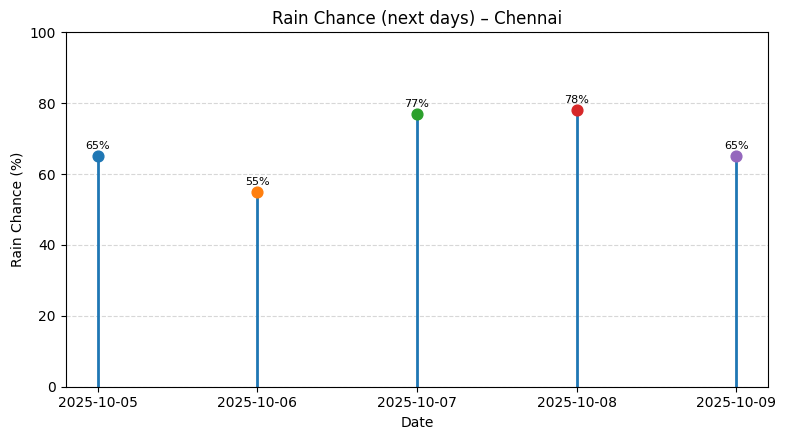

Please select one of the following:
1. View Forecast
2. Ask a Question
3. Visualise Data
4. Exit


In [ ]:
# Include sample input/output for each function
run_app()